参考：http://aidiary.hatenablog.com/entry/20180304/1520172429

In [1]:
import os
import pickle
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

In [4]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(62, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * 7 * 7),
            nn.BatchNorm1d(128 * 7 * 7),
            nn.ReLU(),
        )
        
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )
        
        initialize_weights(self)

    def forward(self, input):
        x = self.fc(input)
        x = x.view(-1, 128, 7, 7)
        x = self.deconv(x)
        return x

In [5]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128 * 7 * 7, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        )
        
        initialize_weights(self)
    
    def forward(self, input):
        x = self.conv(input)
        x = x.view(-1, 128 * 7 * 7)
        x = self.fc(x)
        return x

In [6]:
# Generatorのサイズテスト
G = Generator()
input = torch.rand((32, 62))
out = G(input)
print(out.size())

torch.Size([32, 1, 28, 28])


In [7]:
# Discriminatorのサイズテスト
D = Discriminator()
input = torch.rand((32, 1, 28, 28))
out = D(input)
print(out.size())

torch.Size([32, 1])


In [8]:
# hyperparameters
batch_size = 128
lr = 0.0002
z_dim = 62
num_epochs = 25
sample_num = 16
log_dir = './logs'

In [9]:
# initialize network
G = Generator().to(device)
D = Discriminator().to(device)

# optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# loss
criterion = nn.BCELoss()

In [10]:
# load dataset
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset = datasets.MNIST('data/mnist', train=True, download=True, transform=transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [11]:
def train(D, G, criterion, D_optimizer, G_optimizer, data_loader):
    # 訓練モードへ
    D.train()
    G.train()

    # 本物のラベルは1
    y_real = torch.ones(batch_size, 1)
    # 偽物のラベルは0
    y_fake = torch.zeros(batch_size, 1)
    
    y_real = y_real.to(device)
    y_fake = y_fake.to(device)

    D_running_loss = 0
    G_running_loss = 0
    for batch_idx, (real_images, _) in enumerate(tqdm(data_loader)):
        z = torch.rand((batch_size, z_dim))
        real_images, z = real_images.to(device), z.to(device)

        # Discriminatorの更新
        D_optimizer.zero_grad()

        # Discriminatorにとって本物画像の認識結果は1（本物）に近いほどよい
        # E[log(D(x))]
        D_real = D(real_images)
        D_real_loss = criterion(D_real, y_real)

        # DiscriminatorにとってGeneratorが生成した偽物画像の認識結果は0（偽物）に近いほどよい
        # E[log(1 - D(G(z)))]
        # fake_imagesを通じて勾配がGに伝わらないようにdetach()して止める
        fake_images = G(z)
        D_fake = D(fake_images.detach())
        D_fake_loss = criterion(D_fake, y_fake)

        # 2つのlossの和を最小化する
        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        D_optimizer.step()
        D_running_loss += D_loss.item()

        # Generatorの更新
        z = torch.rand((batch_size, z_dim))
        z = z.to(device)

        G_optimizer.zero_grad()

        # GeneratorにとってGeneratorが生成した画像の認識結果は1（本物）に近いほどよい
        # E[log(D(G(z)))
        fake_images = G(z)
        D_fake = D(fake_images)
        G_loss = criterion(D_fake, y_real)
        G_loss.backward()
        G_optimizer.step()
        G_running_loss += G_loss.item()
    
    D_running_loss /= len(data_loader)
    G_running_loss /= len(data_loader)
    
    return D_running_loss, G_running_loss

In [12]:
def generate(epoch, G, log_dir='logs'):
    G.eval()
    
    os.makedirs(log_dir, exist_ok=True)

    # 生成のもとになる乱数を生成
    sample_z = torch.rand((64, z_dim))
    sample_z = sample_z.to(device)
    
    # Generatorでサンプル生成
    with torch.no_grad():
        samples = G(sample_z).to('cpu')
    save_image(samples, os.path.join(log_dir, 'epoch_%03d.png' % (epoch)))

In [13]:
history = {}
history['D_loss'] = []
history['G_loss'] = []
for epoch in range(num_epochs):
    D_loss, G_loss = train(D, G, criterion, D_optimizer, G_optimizer, data_loader)
    
    print('epoch %d, D_loss: %.4f G_loss: %.4f' % (epoch + 1, D_loss, G_loss))
    history['D_loss'].append(D_loss)
    history['G_loss'].append(G_loss)
    
    # 特定のエポックでGeneratorから画像を生成してモデルも保存
    if epoch == 0 or epoch == 9 or epoch == 24:
        generate(epoch + 1, G, log_dir)
        torch.save(G.state_dict(), os.path.join(log_dir, 'G_%03d.pth' % (epoch + 1)))
        torch.save(D.state_dict(), os.path.join(log_dir, 'D_%03d.pth' % (epoch + 1)))

# 学習履歴を保存
with open(os.path.join(log_dir, 'history.pkl'), 'wb') as f:
    pickle.dump(history, f)

  0%|          | 0/468 [00:00<?, ?it/s]

epoch 1, D_loss: 0.7215 G_loss: 1.3928


  1%|          | 3/468 [00:00<00:18, 25.11it/s]

epoch 2, D_loss: 0.7484 G_loss: 1.5146


  1%|          | 3/468 [00:00<00:19, 24.41it/s]

epoch 3, D_loss: 0.8758 G_loss: 1.3004


  1%|          | 3/468 [00:00<00:19, 23.31it/s]

epoch 4, D_loss: 0.8665 G_loss: 1.3152


  1%|          | 3/468 [00:00<00:18, 24.83it/s]

epoch 5, D_loss: 0.8730 G_loss: 1.3411


  1%|          | 3/468 [00:00<00:18, 24.96it/s]

epoch 6, D_loss: 0.8584 G_loss: 1.3563


  1%|          | 3/468 [00:00<00:18, 24.93it/s]

epoch 7, D_loss: 0.8497 G_loss: 1.3882


  1%|          | 3/468 [00:00<00:20, 22.62it/s]

epoch 8, D_loss: 0.8235 G_loss: 1.4261


  1%|          | 3/468 [00:00<00:18, 25.08it/s]

epoch 9, D_loss: 0.8082 G_loss: 1.4617


  1%|          | 3/468 [00:00<00:19, 24.15it/s]

epoch 10, D_loss: 0.7902 G_loss: 1.5102


  1%|          | 3/468 [00:00<00:19, 23.33it/s]

epoch 11, D_loss: 0.7570 G_loss: 1.5657


  1%|          | 3/468 [00:00<00:21, 21.67it/s]

epoch 12, D_loss: 0.7612 G_loss: 1.5888


  1%|          | 3/468 [00:00<00:19, 24.40it/s]

epoch 13, D_loss: 0.7158 G_loss: 1.6373


  1%|          | 3/468 [00:00<00:19, 23.29it/s]

epoch 14, D_loss: 0.7132 G_loss: 1.6905


  1%|          | 3/468 [00:00<00:20, 22.51it/s]

epoch 15, D_loss: 0.7072 G_loss: 1.7242


  1%|          | 3/468 [00:00<00:18, 24.95it/s]

epoch 16, D_loss: 0.6754 G_loss: 1.7813


  1%|          | 3/468 [00:00<00:19, 24.17it/s]

epoch 17, D_loss: 0.6542 G_loss: 1.8263


  1%|          | 3/468 [00:00<00:19, 24.20it/s]

epoch 18, D_loss: 0.6409 G_loss: 1.8695


  1%|          | 3/468 [00:00<00:20, 23.12it/s]

epoch 19, D_loss: 0.6353 G_loss: 1.8983


  1%|          | 3/468 [00:00<00:19, 24.01it/s]

epoch 20, D_loss: 0.6226 G_loss: 1.9340


  1%|          | 3/468 [00:00<00:21, 21.82it/s]

epoch 21, D_loss: 0.6012 G_loss: 1.9795


  1%|          | 3/468 [00:00<00:21, 22.04it/s]

epoch 22, D_loss: 0.5872 G_loss: 2.0223


  1%|          | 3/468 [00:00<00:18, 24.92it/s]

epoch 23, D_loss: 0.5726 G_loss: 2.0478


  1%|          | 3/468 [00:00<00:20, 22.16it/s]

epoch 24, D_loss: 0.5597 G_loss: 2.0911


100%|██████████| 468/468 [00:19<00:00, 24.23it/s]

epoch 25, D_loss: 0.5585 G_loss: 2.1512


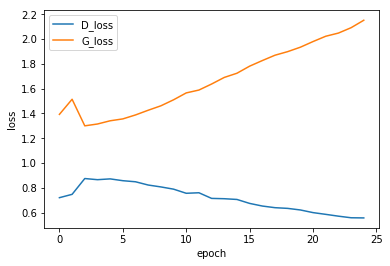

In [14]:
D_loss, G_loss = history['D_loss'], history['G_loss']
plt.plot(D_loss, label='D_loss')
plt.plot(G_loss, label='G_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

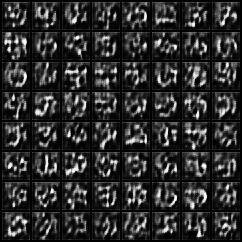

In [15]:
from IPython.display import Image
Image('logs/epoch_001.png')

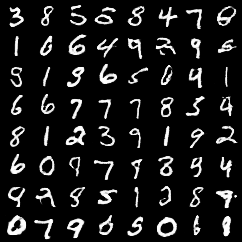

In [16]:
Image('logs/epoch_010.png')

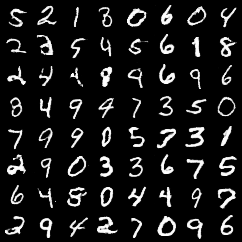

In [17]:
Image('logs/epoch_025.png')

In [18]:
# load dataset
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset = datasets.FashionMNIST('data/fashion-mnist', train=True, download=True, transform=transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)  

(-0.5, 145.5, 145.5, -0.5)

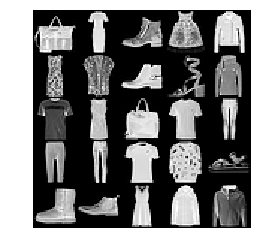

In [19]:
# データの可視化
def imshow(img):
    npimg = img.numpy()
    # [c, h, w] => [h, w, c]
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

images, labels = iter(data_loader).next()
images, labels = images[:25], labels[:25]
imshow(make_grid(images, nrow=5, padding=1))
plt.axis('off')

In [20]:
# initialize network
G = Generator().to(device)
D = Discriminator().to(device)

# optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# loss
criterion = nn.BCELoss()

In [21]:
history = {}
history['D_loss'] = []
history['G_loss'] = []
for epoch in range(num_epochs):
    D_loss, G_loss = train(D, G, criterion, D_optimizer, G_optimizer, data_loader)
    
    print('epoch %d, D_loss: %.4f G_loss: %.4f' % (epoch + 1, D_loss, G_loss))
    history['D_loss'].append(D_loss)
    history['G_loss'].append(G_loss)
    
    # 特定のエポックでGeneratorから画像を生成してモデルも保存
    if epoch == 0 or epoch == 9 or epoch == 24:
        generate(epoch + 1, G, log_dir)
        torch.save(G.state_dict(), os.path.join(log_dir, 'G_%03d.pth' % (epoch + 1)))
        torch.save(D.state_dict(), os.path.join(log_dir, 'D_%03d.pth' % (epoch + 1)))

  1%|          | 3/468 [00:00<00:21, 21.87it/s]

epoch 1, D_loss: 0.7806 G_loss: 1.3001


  1%|          | 3/468 [00:00<00:19, 23.54it/s]

epoch 2, D_loss: 0.8909 G_loss: 1.2889


  1%|          | 3/468 [00:00<00:19, 23.82it/s]

epoch 3, D_loss: 0.9727 G_loss: 1.1882


  1%|          | 3/468 [00:00<00:18, 24.82it/s]

epoch 4, D_loss: 0.9832 G_loss: 1.1705


  1%|          | 3/468 [00:00<00:21, 22.08it/s]

epoch 5, D_loss: 0.9899 G_loss: 1.1678


  1%|          | 3/468 [00:00<00:20, 23.02it/s]

epoch 6, D_loss: 0.9809 G_loss: 1.1834


  1%|          | 3/468 [00:00<00:19, 23.78it/s]

epoch 7, D_loss: 0.9791 G_loss: 1.1949


  1%|          | 3/468 [00:00<00:20, 23.12it/s]

epoch 8, D_loss: 0.9694 G_loss: 1.2105


  1%|          | 3/468 [00:00<00:21, 21.65it/s]

epoch 9, D_loss: 0.9612 G_loss: 1.2265


  1%|          | 3/468 [00:00<00:19, 24.06it/s]

epoch 10, D_loss: 0.9513 G_loss: 1.2429


  1%|          | 3/468 [00:00<00:19, 23.52it/s]

epoch 11, D_loss: 0.9368 G_loss: 1.2648


  1%|          | 3/468 [00:00<00:19, 23.65it/s]

epoch 12, D_loss: 0.9285 G_loss: 1.2855


  1%|          | 3/468 [00:00<00:19, 23.52it/s]

epoch 13, D_loss: 0.9210 G_loss: 1.3027


  1%|          | 3/468 [00:00<00:20, 22.31it/s]

epoch 14, D_loss: 0.9027 G_loss: 1.3300


  1%|          | 3/468 [00:00<00:21, 21.67it/s]

epoch 15, D_loss: 0.8804 G_loss: 1.3637


  1%|          | 3/468 [00:00<00:19, 23.50it/s]

epoch 16, D_loss: 0.8723 G_loss: 1.3811


  1%|          | 3/468 [00:00<00:19, 23.48it/s]

epoch 17, D_loss: 0.8527 G_loss: 1.4073


  1%|          | 3/468 [00:00<00:20, 22.61it/s]

epoch 18, D_loss: 0.8296 G_loss: 1.4426


  1%|          | 3/468 [00:00<00:21, 21.47it/s]

epoch 19, D_loss: 0.8240 G_loss: 1.4737


  1%|          | 3/468 [00:00<00:19, 23.61it/s]

epoch 20, D_loss: 0.8073 G_loss: 1.5085


  1%|          | 3/468 [00:00<00:19, 23.50it/s]

epoch 21, D_loss: 0.7917 G_loss: 1.5261


  1%|          | 3/468 [00:00<00:21, 21.50it/s]

epoch 22, D_loss: 0.7813 G_loss: 1.5659


  1%|          | 3/468 [00:00<00:20, 22.31it/s]

epoch 23, D_loss: 0.7772 G_loss: 1.5853


  1%|          | 3/468 [00:00<00:19, 24.01it/s]

epoch 24, D_loss: 0.7525 G_loss: 1.6208


100%|██████████| 468/468 [00:19<00:00, 24.21it/s]

epoch 25, D_loss: 0.7500 G_loss: 1.6414


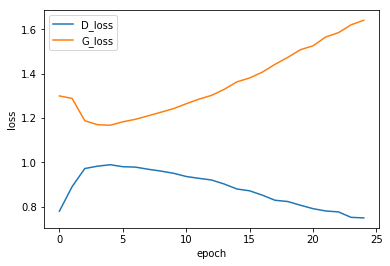

In [22]:
D_loss, G_loss = history['D_loss'], history['G_loss']
plt.plot(D_loss, label='D_loss')
plt.plot(G_loss, label='G_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

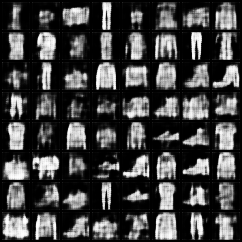

In [23]:
Image('logs/epoch_001.png')

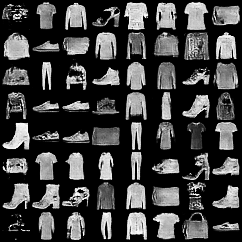

In [24]:
Image('logs/epoch_010.png')

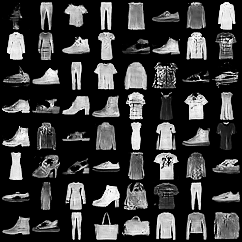

In [25]:
Image('logs/epoch_025.png')

In [26]:
# hyperparameters # 上と同じ。
batch_size = 128
lr = 0.0002
z_dim = 62
num_epochs = 25
sample_num = 16

In [27]:
# load dataset
transform = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])
# celebAの下に直接画像ファイルがあってはダメ！
# クラスのディレクトリが入る必要がある（今回はimg_align_celebaでOK）
dataset = datasets.ImageFolder('data/celebA', transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)  

(-0.5, 325.5, 325.5, -0.5)

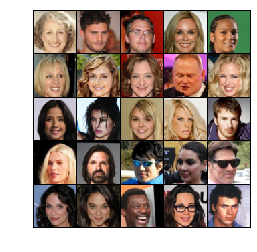

In [28]:
# データの可視化
def imshow(img):
    npimg = img.numpy()
    # [c, h, w] => [h, w, c]
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

images, labels = iter(data_loader).next()
images, labels = images[:25], labels[:25]
imshow(make_grid(images, nrow=5, padding=1))
plt.axis('off')

In [29]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(62, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * 16 * 16),
            nn.BatchNorm1d(128 * 16 * 16),
            nn.ReLU(),
        )
        
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )
        
        initialize_weights(self)

    def forward(self, input):
        x = self.fc(input)
        x = x.view(-1, 128, 16, 16)
        x = self.deconv(x)
        return x

class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128 * 16 * 16, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        )
        
        initialize_weights(self)
    
    def forward(self, input):
        x = self.conv(input)
        x = x.view(-1, 128 * 16 * 16)
        x = self.fc(x)
        return x

In [30]:
# initialize network
G = Generator().to(device)
D = Discriminator().to(device)

# optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# loss
criterion = nn.BCELoss()

In [31]:
history = {}
history['D_loss'] = []
history['G_loss'] = []
for epoch in range(num_epochs):
    D_loss, G_loss = train(D, G, criterion, D_optimizer, G_optimizer, data_loader)
    
    print('epoch %d, D_loss: %.4f G_loss: %.4f' % (epoch + 1, D_loss, G_loss))
    history['D_loss'].append(D_loss)
    history['G_loss'].append(G_loss)
    
    # 特定のエポックでGeneratorから画像を生成してモデルも保存
    if epoch == 0 or epoch == 9 or epoch == 24:
        generate(epoch + 1, G, log_dir)
        torch.save(G.state_dict(), os.path.join(log_dir, 'G_%03d.pth' % (epoch + 1)))
        torch.save(D.state_dict(), os.path.join(log_dir, 'D_%03d.pth' % (epoch + 1)))

100%|██████████| 1582/1582 [08:01<00:00,  3.28it/s]


epoch 1, D_loss: 1.0720 G_loss: 1.0681


  0%|          | 0/1582 [00:00<?, ?it/s]

epoch 2, D_loss: 1.0188 G_loss: 1.1472


  0%|          | 0/1582 [00:00<?, ?it/s]

epoch 3, D_loss: 0.9466 G_loss: 1.2776


  0%|          | 0/1582 [00:00<?, ?it/s]

epoch 4, D_loss: 0.8941 G_loss: 1.3803


  0%|          | 0/1582 [00:00<?, ?it/s]

epoch 5, D_loss: 0.8527 G_loss: 1.4747


  0%|          | 0/1582 [00:00<?, ?it/s]

epoch 6, D_loss: 0.8218 G_loss: 1.5188


  0%|          | 0/1582 [00:00<?, ?it/s]

epoch 7, D_loss: 0.8012 G_loss: 1.5924


  0%|          | 0/1582 [00:00<?, ?it/s]

epoch 8, D_loss: 0.7567 G_loss: 1.6917


  0%|          | 0/1582 [00:00<?, ?it/s]

epoch 9, D_loss: 0.7435 G_loss: 1.7382


100%|██████████| 1582/1582 [08:16<00:00,  3.19it/s]


epoch 10, D_loss: 0.7241 G_loss: 1.8042


  0%|          | 0/1582 [00:00<?, ?it/s]

epoch 11, D_loss: 0.6882 G_loss: 1.8892


  0%|          | 0/1582 [00:00<?, ?it/s]

epoch 12, D_loss: 0.6585 G_loss: 1.9545


  0%|          | 0/1582 [00:00<?, ?it/s]

epoch 13, D_loss: 0.6344 G_loss: 2.0347


  0%|          | 0/1582 [00:00<?, ?it/s]

epoch 14, D_loss: 0.5990 G_loss: 2.1344


  0%|          | 0/1582 [00:00<?, ?it/s]

epoch 15, D_loss: 0.5706 G_loss: 2.2141


  0%|          | 0/1582 [00:00<?, ?it/s]

epoch 16, D_loss: 0.5629 G_loss: 2.2851


  0%|          | 0/1582 [00:00<?, ?it/s]

epoch 17, D_loss: 0.5763 G_loss: 2.3619


  0%|          | 0/1582 [00:00<?, ?it/s]

epoch 18, D_loss: 0.5070 G_loss: 2.4665


  0%|          | 0/1582 [00:00<?, ?it/s]

epoch 19, D_loss: 0.5147 G_loss: 2.5155


  0%|          | 0/1582 [00:00<?, ?it/s]

epoch 20, D_loss: 0.4770 G_loss: 2.6207


  0%|          | 0/1582 [00:00<?, ?it/s]

epoch 21, D_loss: 0.4808 G_loss: 2.6926


  0%|          | 0/1582 [00:00<?, ?it/s]

epoch 22, D_loss: 0.4345 G_loss: 2.7890


  0%|          | 0/1582 [00:00<?, ?it/s]

epoch 23, D_loss: 0.4433 G_loss: 2.8769


  0%|          | 0/1582 [00:00<?, ?it/s]

epoch 24, D_loss: 0.4227 G_loss: 2.9311


100%|██████████| 1582/1582 [07:51<00:00,  3.35it/s]


epoch 25, D_loss: 0.4619 G_loss: 2.9709


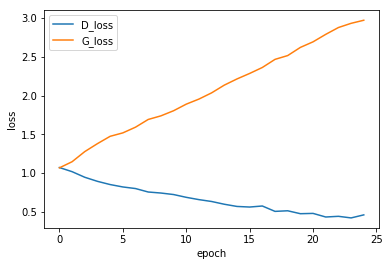

In [32]:
D_loss, G_loss = history['D_loss'], history['G_loss']
plt.plot(D_loss, label='D_loss')
plt.plot(G_loss, label='G_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

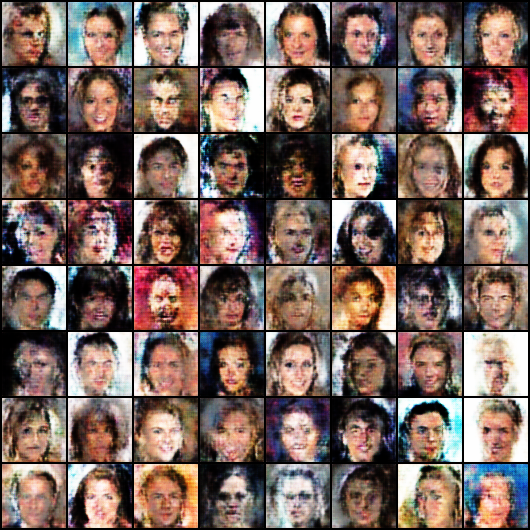

In [33]:
Image('logs/epoch_001.png')

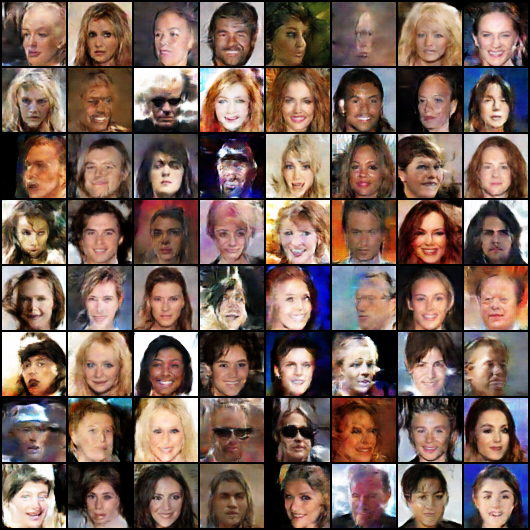

In [34]:
Image('logs/epoch_010.png')

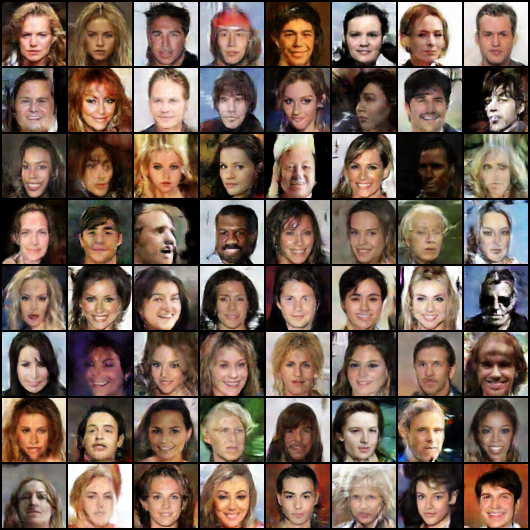

In [35]:
Image('logs/epoch_025.png')